### Inserting Libraries

In [1]:
import spotipy
import credentials
from tqdm import tqdm_notebook as tqdm
from spotipy.oauth2 import SpotifyClientCredentials, is_token_expired
import pandas as pd

### Setting up API credentials

In [2]:
# You should create a credentials.py in your repo with credentials in it

In [4]:
client_credentials_manager = SpotifyClientCredentials(client_id=credentials.client_id,client_secret=credentials.client_secret)

In [5]:
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Function that given a user_id returns all the data

In [6]:
def get_all_data(user_id):
    
    #get all the playlist id's
    
    track_list = []
    sname_list = []
    artist_list = []
    audio_ft = []
    
        
    for playlist in tqdm(sp.user_playlists(user_id)['items']):
            for idx,track in enumerate(sp.playlist_tracks(playlist['id'])['items']):
                if track['track']['id'] is not None:
                    
                    track_list.append(track['track']['id'])
                    sname_list.append(track['track']['name'])
                    artist_list.append(track['track']['album']['artists'][0])
                    #print(track['track']['id'])
                    audio_ft.append(sp.audio_features(track['track']['id'])[0])
    
    df = pd.DataFrame({'name': sname_list,
                       'artist': artist_list,
                       'id': track_list,
                       'audio_ft': audio_ft})
    
    return df

            

In [7]:
df = get_all_data('11101312700')

/home/tomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [8]:
# Time to transform the data in order to be clean

In [9]:
def transform_data(df):
    
    df['artist'] = df['artist'].apply(pd.Series)['name']
    
    df = pd.concat([df,df['audio_ft'].apply(pd.Series)], axis=1)
    
    df = df.drop(labels=['time_signature','duration_ms','analysis_url','track_href','type','audio_ft'], axis=1)
    
    return df
    
    
    

In [10]:
df = transform_data(df)

In [11]:
df.head()

name           artist                      id  \
0              Brokendate       Com Truise  2kmX8QNMLg72Vy9Ux6mdmi   
1               Crimewave  Crystal Castles  3yQFmN8A5S8Kf1nUJuvb01   
2                Vanished  Crystal Castles  0exOxvY3iHsmAnGHiJYAZq   
3  Lady - Hear Me Tonight            Modjo  49X0LAl6faAusYq02PRAY6   
4          Baby I'm Yours         Breakbot  0tZkVZ9DeAa0MNK2gY5NtV   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.526   0.544   11    -7.137     1       0.1690       0.25800   
1         0.746   0.691    4    -7.533     0       0.0403       0.18400   
2         0.713   0.868    0    -6.644     0       0.0305       0.00206   
3         0.720   0.808    6    -5.627     1       0.0379       0.00793   
4         0.829   0.792    2    -3.755     0       0.0668       0.72600   

   instrumentalness  liveness  valence    tempo                      id  \
0          0.640000    0.3770    0.544  170.370  2kmX8QNMLg72Vy9Ux6mdmi   
1          0.025900    0.2050    0.888  119.982  3yQFmN8A5S8Kf1nUJuvb01   
2          0.000092    0.2250    0.641  119.980  0exOxvY3iHsmAnGHiJYAZq   
3          0.029300    0.0634    0.869  126.041  49X0LAl6faAusYq02PRAY6   
4          0.000006    0.1220    0.758  118.050  0tZkVZ9DeAa0MNK2gY5NtV   

                                    uri  
0  spotify:track:2kmX8QNMLg72Vy9Ux6mdmi  
1  spotify:track:3yQFmN8A5S8Kf1nUJuvb01  
2  spotify:track:0exOxvY3iHsmAnGHiJYAZq  
3  spotify:track:49X0LAl6faAusYq02PRAY6  
4  spotify:track:0tZkVZ9DeAa0MNK2gY5NtV

Now we have all the songs of our playlist in a data frame with each audio feature, time to do some magic

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [13]:
features = ['danceability','energy','acousticness'
           ,'instrumentalness','valence']

In [14]:
scaler = MinMaxScaler()

scaled = pd.DataFrame(scaler.fit_transform(df[features]))
scaled.columns = features


In [15]:
def calculate_wcss(data):
    wcss = []
    for n in range(1, 15):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

In [16]:
wcss = calculate_wcss(scaled)

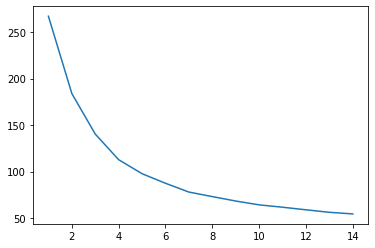

In [17]:
sns.lineplot(x=range(1,15), y=wcss)

In [18]:
kmeans = KMeans(n_clusters=5).fit(scaled)

In [19]:
y_kmeans = kmeans.predict(scaled)

In [20]:
centroids = kmeans.cluster_centers_
centroids

array([[0.52812411, 0.6784423 , 0.1029362 , 0.02945371, 0.29435343],
       [0.65537209, 0.75321635, 0.13010362, 0.01769351, 0.70349072],
       [0.6244338 , 0.69465741, 0.08514106, 0.79821181, 0.54679819],
       [0.55692459, 0.35923053, 0.66431342, 0.81312859, 0.23009845],
       [0.53460801, 0.38781873, 0.68200216, 0.02605068, 0.32815445]])

In [21]:
scaled = scaler.fit_transform(scaled)

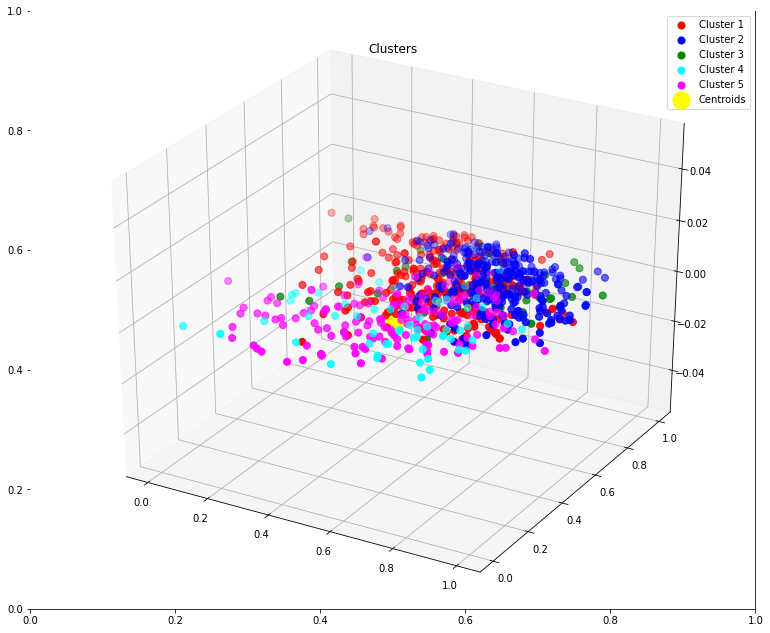

In [22]:
from mpl_toolkits.mplot3d import Axes3D
# visualizing clusters
fig, ax = plt.subplots(figsize=(13,11))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(scaled[y_kmeans == 0,0],scaled[y_kmeans == 0,1], s= 50, c= 'red',label= 'Cluster 1')
plt.scatter(scaled[y_kmeans == 1,0], scaled[y_kmeans == 1,1], s= 50, c= 'blue', label= 'Cluster 2')
plt.scatter(scaled[y_kmeans == 2,0], scaled[y_kmeans == 2,1], s= 50, c= 'green', label= 'Cluster 3')
plt.scatter(scaled[y_kmeans == 3,0], scaled[y_kmeans == 3,1], s= 50, c= 'cyan', label= 'Cluster 4')
plt.scatter(scaled[y_kmeans == 4,0], scaled[y_kmeans == 4,1], s= 50, c= 'magenta', label= 'Cluster 5')


# centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
plt.title('Clusters')
plt.legend()
plt.show()

In [23]:
kmeans_pred = pd.DataFrame(data=y_kmeans, dtype=int, columns=['k_cluster'])
kmeans_pred

k_cluster
0            2
1            1
2            1
3            1
4            1
..         ...
872          1
873          1
874          1
875          4
876          1

[877 rows x 1 columns]

In [24]:
df_cluster = pd.concat([df, kmeans_pred], axis = 1)

In [25]:
cluster_stats = pd.DataFrame(columns=features)
for n in range(5):   
    cluster_stats = cluster_stats.append(df_cluster[df_cluster.k_cluster == n][features].mean(), ignore_index=True)
       

In [26]:
cluster_stats_scaled = pd.DataFrame(scaler.fit_transform(cluster_stats))
cluster_stats_scaled.columns = features
cluster_stats

danceability    energy  acousticness  instrumentalness   valence
0      0.539704  0.682958      0.101771          0.029180  0.313924
1      0.655535  0.754741      0.129461          0.016138  0.700060
2      0.626817  0.698283      0.084463          0.766283  0.551588
3      0.566207  0.374529      0.659000          0.780603  0.252212
4      0.546171  0.402123      0.676547          0.025009  0.344904

In [27]:
cluster_stats_scaled

danceability    energy  acousticness  instrumentalness   valence
0      0.000000  0.811203      0.029232          0.017060  0.137797
1      1.000000  1.000000      0.075999          0.000000  1.000000
2      0.752068  0.851511      0.000000          0.981268  0.668477
3      0.228805  0.000000      0.970364          1.000000  0.000000
4      0.055830  0.072574      1.000000          0.011604  0.206973

In [28]:
from math import pi

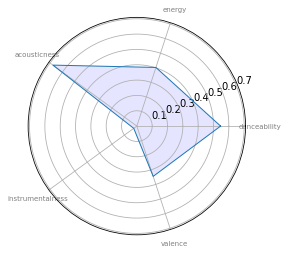

In [29]:
categories = list(cluster_stats)
N = len(categories)


values = cluster_stats.loc[4].values.flatten().tolist()
values += values[:1]


angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax = plt.subplot(111, polar=True)

plt.xticks(angles[:-1], categories, color='grey', size=7)

ax.plot(angles, values, linewidth=1, linestyle='solid')

ax.fill(angles,values, 'b', alpha=0.1)

In [30]:
def make_spider(row, title, color):
    #number of variable
    
    categories=list(cluster_stats)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    #initialize spider
    ax = plt.subplot(2,3,row+1,polar=True)
    
    ax.set_theta_offset(pi/2)
    ax.set_theta_direction(-1)
                
    plt.xticks(angles[:-1], categories, color='grey', size=7)
    plt.ylim(0,1)
                
    #
    values=cluster_stats.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    #title
    plt.title(title, size=11, color=color, y=1.1)

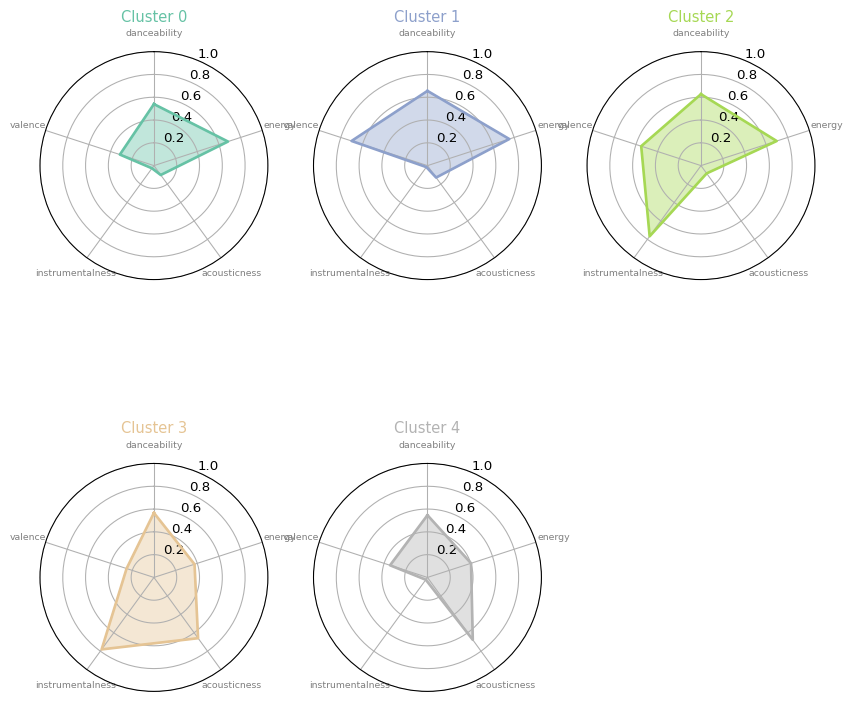

In [31]:
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

my_palette = plt.cm.get_cmap("Set2", len(cluster_stats_scaled.index))

for row in range(0, len(cluster_stats_scaled.index)):
    make_spider(row=row, title='Cluster {}'.format(row), color=my_palette(row))

In [56]:
def create_cluster_playlist(df, user_id):
    for cluster in df['k_cluster'].value_counts().index.tolist():
        uris = df[df.k_cluster == cluster]['uri'].tolist()
        ##Create playlist
        create_playlist_endpoint = f"https://api.spotify.com/v1/users/{user_id}/playlists"
        request_body_playlist = json.dumps({
            "name": f"Cluster {cluster} Playlist",
            "description": f"This is the playlist of the cluster number {cluster}, created with k-means algo",
            "public": True
        })
        h={
            "Content-Type": "application/json",
            "Authorization": "Bearer {}".format(credentials.auth)
            
        }
        ## Make the post to create the playlist
        response = requests.post(url=create_playlist_endpoint, data=request_body_playlist, headers=h)
        
        if response.status_code == 201:
            print("La playlist del cluster {} fue correctamente creada".format(cluster))
        else:
            print("Hubo un error en la creacion de la playlist del cluster {}".format(cluster))
            print(response.status_code)
            
            continue
        
        print("Agregando canciones a la playlist")
        ## Parameters for the other request
        
        playlist_id = response.json()['id']
        add_track_endpoint = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
        
        request_add_tracks = json.dumps({
            "uris": uris
        })
        
        response = requests.post(url=add_track_endpoint, data=request_add_tracks, headers=h)
        
        if response.status_code == 201:
            print(f"Se agregaron {len(uris)} canciones a la playlist")
        else:
            print(f"Error al agregar canciones a la playlist")
            print(response.status_code)
            print(len(uris))
            continue
        
    
    
    print("Finalizada la creacion de las playlist")
        
        

In [ ]:
def _generate_token( client_id, client_secret):
        credentials = oauth2.SpotifyClientCredentials(
            client_secret=client_secret,
        )
        token = credentials.get_access_token()
        return token 



In [57]:
import requests 
import json
user_id = '11101312700'
create_cluster_playlist(df_cluster, user_id)

Hubo un error en la creacion de la playlist del cluster 1
401
Hubo un error en la creacion de la playlist del cluster 0
401
Hubo un error en la creacion de la playlist del cluster 4
401
Hubo un error en la creacion de la playlist del cluster 2
401
Hubo un error en la creacion de la playlist del cluster 3
401
Finalizada la creacion de las playlist


In [95]:
import requests 
import json

auth = "BQANgLLwADh0BokY06ELouHHNYUMeoS6E2tj6MOVtq7oxpbBKOc3P76Vd0lWtXy6BzhEJPiIjWpUUEmgrgeQat7q1xNUUMIVV3tFJ59Y-EabmO6T3uHAPEg1LaUXpHUicuzoPy_cloUz30KyzNiLcgfxSKMASOgaDO1_qrLFgaD8SbQB8-lbrQhO_F7b6ll9Na8hrDK9oya2l-EnpqG6Jau5QZ1g9_3REhbZkfrHOmvDVICRrCZ_Smx6DrkgH-qQlrG26Lmrj1Up0T7VRw"
user_id = '11101312700'
endpoint_url = f"https://api.spotify.com/v1/users/{user_id}/playlists"
request_body = json.dumps({
    "name": "testing rq",
    "description": "test",
    "public": False
})

response = requests.post(url=endpoint_url, data=request_body, headers= {"Content-Type": "application/json",
                        "Authorization": "Bearer {}".format(auth)})

In [102]:
response.status_code

201

In [84]:
playlist_id = response.json()['id']

endpoint_url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
request_body = json.dumps({
    "uris" : uris
})

response = requests.post(url = endpoint_url, data= request_body, headers={"Content-Type":"application/json",
                                                                        "Authorization": "Bearer {}".format(auth)})

In [85]:
response

<Response [201]>

In [52]:
asd = df_cluster['k_cluster'].value_counts().index.tolist()

In [53]:
asd

[1, 0, 4, 2, 3]

In [94]:
response.json()

{'snapshot_id': 'MyxhMmFmNjMxYzM1ZDliYzM1MjQxODgzMzMwM2VjNDhmNjEyNGU1MGYy'}